# Step 3: Population definition refinement based on the results of the 1st iteration of the population-specific PCA

In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


## Step 3-0) Read the file names

In [2]:
source('0_file_names.R')


In [3]:
file_names <- get_file_names()

## Step 3-1) Check the PCA plots from the previous step

- We check plots in `/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification_w24983_20200828/pca1_refinement`.
- It seems like `e_asian` and `s_asian` need population refinement


## Step 3-2) Browse the plots 

- Let's use IQR as a guide for setting threshold


In [4]:
compute_IQR_based_thresholds <- function(df){
    
    Q1 <- quantile(df$PC1, probs=c(.25, .75), na.rm = FALSE)
    PC1_low <- Q1[1]-1.5*IQR(df$PC1, na.rm = FALSE)
    PC1_up  <- Q1[2]+1.5*IQR(df$PC1, na.rm = FALSE)

    Q2 <- quantile(df$PC2, probs=c(.25, .75), na.rm = FALSE)
    PC2_low <- Q2[1]-1.5*IQR(df$PC2, na.rm = FALSE)
    PC2_up  <- Q2[2]+1.5*IQR(df$PC2, na.rm = FALSE)

    thrs <- setNames(
        unname(c(PC1_low, PC1_up, PC2_low, PC2_up)),
        c('PC1_low', 'PC1_up', 'PC2_low', 'PC2_up')
    )    
    
    return(thrs)
}

In [5]:
plot_PCs_with_thr <- function(df, thrs){
    
    df %>%
    ggplot(aes(x=PC1, y = PC2)) +
    geom_point(alpha=.05) +
    theme_bw() -> p
    
    for(thr_key in c('PC1_low', 'PC1_up')){
        if(thr_key %in% names(thrs)){
            p + geom_vline(
                xintercept = thrs[[thr_key]], color='gray'
            ) -> p
        }
    }

    for(thr_key in c('PC2_low', 'PC2_up')){
        if(thr_key %in% names(thrs)){
            p + geom_hline(
                yintercept = thrs[[thr_key]], color='gray'
            ) -> p
        }
    }
    
    if( ('PC1_PC2_ab_slope' %in% names(thrs)) & ('PC1_PC2_ab_intercept' %in% names(thrs)) ){
        p + geom_abline(
            slope=thrs[['PC1_PC2_ab_slope']],
            intercept=thrs[['PC1_PC2_ab_intercept']], 
            color='gray'
        ) -> p
    }

    p
}


In [6]:
count_outlier_individuals_with_thr <- function(df, thrs){
    
    df %>% mutate(not_outlier = TRUE) -> df
    
    if('PC1_low' %in% names(thrs)){
        df %>% mutate(
            not_outlier = not_outlier & (thrs[['PC1_low']] <= PC1)
        ) -> df
    }

    if('PC1_up' %in% names(thrs)){
        df %>% mutate(
            not_outlier = not_outlier & (PC1 <= thrs[['PC1_up']])
        ) -> df
    }

    if('PC2_low' %in% names(thrs)){
        df %>% mutate(
            not_outlier = not_outlier & (thrs[['PC2_low']] <= PC2)
        ) -> df
    }

    if('PC2_up' %in% names(thrs)){
        df %>% mutate(
            not_outlier = not_outlier & (PC2 <= thrs[['PC2_up']])
        ) -> df
    } 
    
    if( ('PC1_PC2_ab_slope' %in% names(thrs)) & ('PC1_PC2_ab_intercept' %in% names(thrs)) & ('PC1_PC2_ab_direction' %in% names(thrs)) ){
        
        if( thrs[['PC1_PC2_ab_direction']] == 'geq'){
            message('y >= ax + b')
        # y >= ax + b
            df %>% mutate(
                not_outlier = not_outlier & ( PC2 >= ( thrs[['PC1_PC2_ab_slope']] * PC1 + thrs[['PC1_PC2_ab_intercept']] ))
            ) -> df
            
        }else if( thrs[['PC1_PC2_ab_direction']] == 'leq' ){
            message('y <= ax + b')            
        # y <= ax + b
            
            df %>% mutate(
                not_outlier = not_outlier & ( PC2 <= ( thrs[['PC1_PC2_ab_slope']] * PC1 + thrs[['PC1_PC2_ab_intercept']] ))
            ) -> df

        }else{
            message(sprintf('unsupported direction %s', thrs[['PC1_PC2_ab_direction']]))
        }        
    } 
    
    df
}


In [7]:
pop_PC_dfs <- list()
thrs_IQR <- list()
plots_IQR <- list()

for(pop in c('s_asian')){
    message(pop)
    file.path(file_names$pop_refinement_pca, sprintf('ukb24983_%s.eigenvec', pop)) %>%
    fread(select=c('#FID', 'IID', 'PC1', 'PC2'), colClasses=c('#FID'='character', 'IID'='character')) %>%
    rename('FID' = '#FID') -> pop_PC_dfs[[pop]]

    thrs_IQR[[pop]] <- compute_IQR_based_thresholds(pop_PC_dfs[[pop]])

    pop_PC_dfs[[pop]] %>%
    count_outlier_individuals_with_thr(thrs_IQR[[pop]]) -> pop_PC_dfs[[pop]]
   
    pop_PC_dfs[[pop]] %>%
    plot_PCs_with_thr(thrs_IQR[[pop]]) -> plots_IQR[[pop]]
}


s_asian



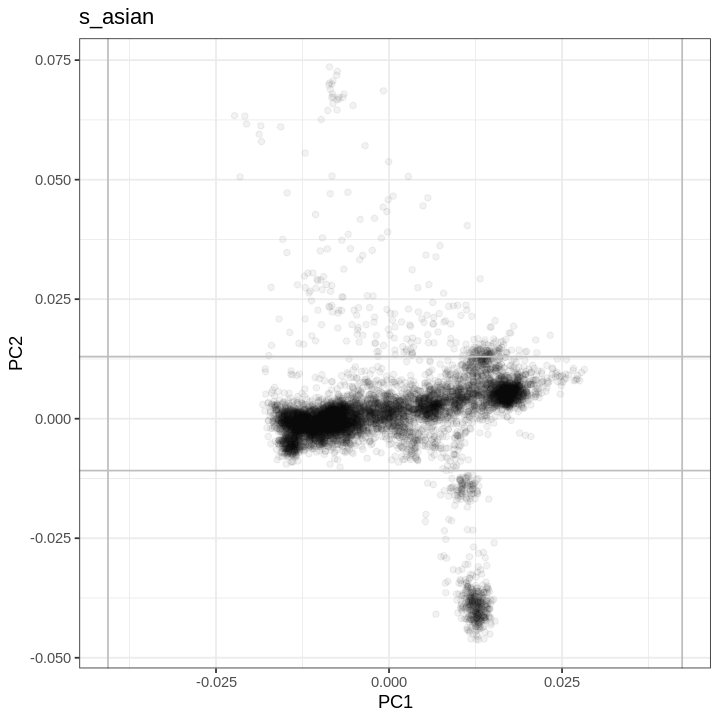

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
plots_IQR[['s_asian']] + labs(title = 's_asian')


In [9]:
thrs_IQR

$s_asian
    PC1_low      PC1_up     PC2_low      PC2_up 
-0.04061198  0.04235419 -0.01085297  0.01298648

In [10]:
for(pop in c('s_asian')){
    message(pop)
    pop_PC_dfs[[pop]] %>%
    count(not_outlier) %>% print()
}


s_asian



   not_outlier    n
1:       FALSE  776
2:        TRUE 7186


## Step 3-3) Population definition refinement based on the local PCs

- White British: No update
- Non-British White: No update
- African: No update
- South Asian: filtering out some individuals
  - `PC2 <= 0.02`
- East Asian: No update (smartpca in EIG already applied outlier removal)


In [11]:
thrs_manual <- list(
    's_asian' = list('PC2_up' = 0.02)
)


In [12]:
thrs_manual

$s_asian
$s_asian$PC2_up
[1] 0.02

In [13]:
plots_manual <- list()


In [14]:
for(pop in c('s_asian')){
    message(pop)
    
    pop_PC_dfs[[pop]] %>%
    count_outlier_individuals_with_thr(thrs_manual[[pop]]) -> pop_PC_dfs[[pop]]
    
    pop_PC_dfs[[pop]] %>%
    plot_PCs_with_thr(thrs_manual[[pop]]) -> plots_manual [[pop]]
}


s_asian



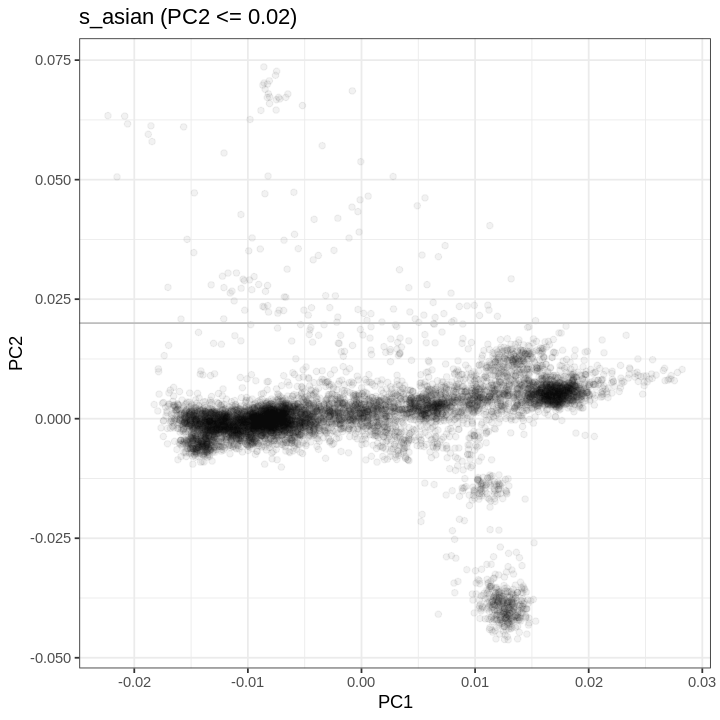

In [15]:
options(repr.plot.width=6, repr.plot.height=6)
plots_manual[['s_asian']] + labs(title = 's_asian (PC2 <= 0.02)')


In [16]:
for(pop in c('s_asian')){
    message(pop)
    pop_PC_dfs[[pop]] %>%
    count(not_outlier) %>% print()
}


s_asian



   not_outlier    n
1:       FALSE  131
2:        TRUE 7831


## Step 3-4) Save the results of population definition refinement

In [17]:
for (pop in c('s_asian')){
    message(pop)
    
    pop_PC_dfs[[pop]] %>%
    filter(not_outlier) %>%
    select(FID, IID) %>% 
    fwrite(file.path(file_names$pop_specific_pca, paste0('ukb24983_', pop, '.phe')), sep='\t', col.names = F)    
}


s_asian



In [18]:
ggsave('figs/3_population_refinement.png', plots_manual[['s_asian']] + labs(title = 's_asian (PC2 <= 0.02)'), width=6, height=6)
ggsave('figs/3_population_refinement.pdf', plots_manual[['s_asian']] + labs(title = 's_asian (PC2 <= 0.02)'), width=6, height=6)
